<a href="https://colab.research.google.com/github/MariaDimopoulou/HandwrittenDigits/blob/main/HandWrittenDigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


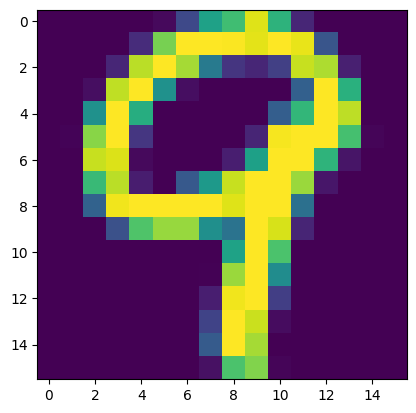

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import svd, norm

xtrain=pd.read_excel('data.xlsx',sheet_name='azip',header=None)
ytrain=pd.read_excel('data.xlsx',sheet_name='dzip',header=None)
xtest=pd.read_excel('data.xlsx',sheet_name='testzip',header=None)
ytest=pd.read_excel('data.xlsx',sheet_name='dtest',header=None)

def show_digit(num_of_column,data): # takes a column number and displays the corresponding digit using matplotlib
    data_image=np.array(data.iloc[:,num_of_column])
    image=np.reshape(data_image,(16,16))
    plt.imshow(image)
    plt.show()
show_digit(0,xtest)

In [3]:
# Here, we create a dictionary named 'matrices' to store matrices for each digit.
matrices = {}

# Iterate through digits from 0 to 9
for i in range(10):
     matrices.update({"A"+str(i):xtrain.loc[:,list(ytrain.loc[0,:]==i)]})

In [5]:
left_singular={}
singular_matix={}
right_singular={}
for i in range(10):
    u, s, v_t = svd(matrices['A'+str(i)], full_matrices=False) #svd for every matrix of each digit
    left_singular.update({"u"+str(i):u})
    singular_matix.update({"s"+str(i):s})
    right_singular.update({"v_t"+str(i):v_t})


The code iteratively applies a digit classification approach using singular value decomposition with varying numbers of basis vectors (kappas). It evaluates and prints the accuracy scores for each classification attempt on a test dataset, displaying the performance for different levels of feature representation.

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
I = np.eye(xtest.shape[0])
kappas=np.arange(5,21)
len_test=xtest.shape[1]
predictions=np.empty((ytest.shape[1],0), dtype = int)
for t in list(kappas):
    prediction = []
    for i in range(len_test):
        residuals = []
        for j in range(10):
            u=left_singular["u"+str(j)][:,0:t]
            res=norm( np.dot(I-np.dot(u,u.T), xtest[i]  ))/norm(xtest[i]) # relative residual
            residuals.append(res)
        index_min = np.argmin(residuals)
        prediction.append(index_min) #the smallest residual is the digit that we see

    prediction=np.array(prediction)
    predictions=np.hstack((predictions,prediction.reshape(-1,1)))
scores=[]
for i in range(len(kappas)):
    score=accuracy_score(ytest.loc[0,:],predictions[:,i])
    scores.append(score)
data={"Number of basis vectors":list(kappas), "accuracy_score":scores}
df=pd.DataFrame(data).set_index("Number of basis vectors")
print(df)


                         accuracy_score
Number of basis vectors                
5                              0.902840
6                              0.905331
7                              0.916791
8                              0.920279
9                              0.926258
10                             0.931739
11                             0.932237
12                             0.935725
13                             0.936223
14                             0.939213
15                             0.941206
16                             0.938714
17                             0.939213
18                             0.941704
19                             0.940708
20                             0.939711


In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame( confusion_matrix(ytest.loc[0,:],predictions[:,13]) ) #We are using 18 vectors as it had the biggest accuracy in the previous section
print(confusion_matrix_df)

     0    1    2    3    4    5    6    7    8    9
0  355    0    2    0    1    0    0    0    0    1
1    0  259    0    0    3    0    2    0    0    0
2    8    1  178    2    5    0    0    1    3    0
3    2    0    3  150    1    6    0    1    2    1
4    2    1    0    0  185    2    0    3    0    7
5    7    1    1    5    0  141    0    0    2    3
6    2    1    0    0    2    1  163    0    1    0
7    0    1    1    0    3    0    0  141    0    1
8    2    0    1    6    0    1    0    0  153    3
9    0    2    0    1    4    0    0    3    2  165


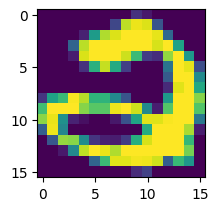

None


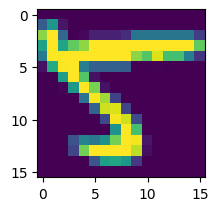

None


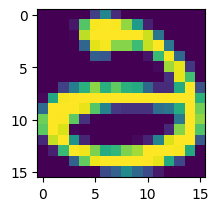

None


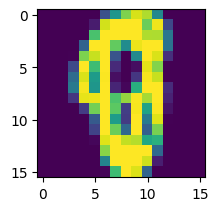

None


In [10]:
import matplotlib.pyplot as plt
#From confusion matrix we can see that some common missconseption are mixing up 2 with 0 and 4,  3 with 5, 4 with 9 etc
#Below we can see some of the digits that were wrongly predicted. We can see that they are mostly bad written.
misclassified =np.array(np.where(ytest.loc[0,:] != predictions[:,13]))
pic1=plt.subplot(2,2,1)
print(show_digit(misclassified[0][7],xtest))
pic2=plt.subplot(2,2,2)
print(show_digit(misclassified[0][1],xtest))
pic3=plt.subplot(2,2,3)
print(show_digit(misclassified[0][2],xtest))
pic3=plt.subplot(2,2,4)
print(show_digit(misclassified[0][8],xtest))


The function changes assesses the classification accuracy on the test dataset by selectively modifying the number of basis vectors used for one specific digit, while keeping the others constant.

In [11]:
def changes(digit_dif,vectors_dif):
    prediction=[]
    for i in range (xtest.shape[1]):
        residuals=[]
        for j in range(10):
            if j==digit_dif:
                u=left_singular["u"+str(j)][:,0:vectors_dif]
                res=norm(np.dot(I-np.dot(u,u.T), xtest[i]))/norm(xtest[i]) #relative residual
                residuals.append(res)
            else:
                u=left_singular["u"+str(j)][:,0:18]
                res=norm(np.dot(I-np.dot(u,u.T), xtest[i]))/norm(xtest[i])
                residuals.append(res)
        index_min = np.argmin(residuals)
        prediction.append(index_min)
    prediction=np.array(prediction)
    score=accuracy_score(ytest.loc[0,:],prediction)
    return score
print(changes(1,18))
print(changes(1,11))
print(changes(0,13))
print(changes(2,20))


0.9417040358744395
0.9422022919780767
0.9431988041853513
0.9436970602889886
